Chức năng của file: Tìm ra tham số C phù hợp của mỗi mô hình đang có dấu hiệu overfit.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import time
import seaborn as sns
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [8]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X, y), (X_test, y_test) = fashion_mnist.load_data()

X = X.reshape(X.shape[0], -1)
X = X.astype('float32') / 255.0

X_test = X_test.reshape(X_test.shape[0], -1)
X_test = X_test.astype('float32') / 255.0

In [9]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [10]:
def evaluate(y_true, y_pred, data_set_name):

  print(f'----------------{data_set_name}----------------')
  accuracy_logReg = accuracy_score(y_true, y_pred)
  print(f'Accuracy: {accuracy_logReg:.3f}')

  precision_logReg = precision_score(y_true, y_pred, average='weighted')
  print(f'Precision: {precision_logReg:.3f}')

  recall_logReg = recall_score(y_true, y_pred, average='weighted')
  print(f'Recall: {recall_logReg:.3f}')

  confusion_matrix_logReg = confusion_matrix(y_true, y_pred)
  print('Confusion Matrix:\n', confusion_matrix_logReg)

  print(classification_report(y_true, y_pred, target_names=fashion_mnist_labels))

def create_data(X, y, X_test, n_components=100, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    if n_components < 100:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)
    return X_train, X_val, y_train, y_val, X_test

def train_predict_evaluate_each_parameter(X_train, y_train, X_test, y_test, solver='lbfgs', max_iter=10000, penalty=None, tol=1e-4, verbose=0, C=1):
  
  model_logReg = LogisticRegression(multi_class='multinomial', solver=solver, max_iter=max_iter, penalty=penalty, tol=tol, verbose=verbose, C=C)
  model_logReg.fit(X_train, y_train)

  y_pred_training = model_logReg.predict(X_train)
  evaluate(y_train, y_pred_training, 'Trainning set')

  y_pred_testing = model_logReg.predict(X_test)
  evaluate(y_test, y_pred_testing, 'Validation set')

***Tìm C phù hợp với solver 'lbfgs', tỷ lệ 7/3 để tiến hành hiệu chỉnh***

In [11]:
# Với tỷ lệ train/validation : 7/3
X_train1, X_val1, y_train1, y_val1, X_test1 = create_data(X=X, y=y, X_test=X_test, n_components=100, test_size=0.3)
X_train1.shape, X_val1.shape, X_test1.shape

((42000, 784), (18000, 784), (10000, 784))

In [12]:
# Chọn C với solver 'lbfgs' và tỷ lệ train/validation : 7/3
model_logReg = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2', n_jobs=-1)

parameters = {'solver' : ['lbfgs'],
         'C' : np.logspace(-8, 2, 11)}

clf = GridSearchCV(model_logReg, parameters, cv=3, n_jobs=-1)
clf.fit(X_train1, y_train1)
results = clf.cv_results_
best_parameter = clf.best_params_
best_score = clf.best_score_

In [13]:
data = pd.DataFrame(results)
data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.041838,0.019873,0.094577,0.003312,0.0,lbfgs,"{'C': 1e-08, 'solver': 'lbfgs'}",0.298500,0.310357,0.314000,0.307619,0.006617,11
1,2.989465,0.141636,0.092026,0.004126,0.0,lbfgs,"{'C': 1e-07, 'solver': 'lbfgs'}",0.624286,0.623571,0.629214,0.625690,0.002509,10
2,3.716943,0.168110,0.091442,0.008814,0.000001,lbfgs,"{'C': 1e-06, 'solver': 'lbfgs'}",0.630714,0.630500,0.634786,0.632000,0.001972,9
3,6.267199,0.151488,0.084604,0.001023,0.00001,lbfgs,"{'C': 1e-05, 'solver': 'lbfgs'}",0.668786,0.672000,0.672857,0.671214,0.001753,8
4,22.938821,0.741166,0.086775,0.002932,0.0001,lbfgs,"{'C': 0.0001, 'solver': 'lbfgs'}",0.734714,0.735929,0.736071,0.735571,0.000609,7
5,48.880284,1.874149,0.116488,0.039526,0.001,lbfgs,"{'C': 0.001, 'solver': 'lbfgs'}",0.801857,0.801714,0.806786,0.803452,0.002358,6
6,74.438304,3.498599,0.085380,0.001867,0.01,lbfgs,"{'C': 0.01, 'solver': 'lbfgs'}",0.839786,0.839857,0.844929,0.841524,0.002408,3
7,130.175497,5.517545,0.086857,0.001241,0.1,lbfgs,"{'C': 0.1, 'solver': 'lbfgs'}",0.852286,0.852500,0.854714,0.853167,0.001098,1
8,298.769001,5.353539,0.109774,0.026862,1.0,lbfgs,"{'C': 1.0, 'solver': 'lbfgs'}",0.848286,0.846571,0.845357,0.846738,0.001201,2
9,761.893393,11.296143,0.087300,0.001371,10.0,lbfgs,"{'C': 10.0, 'solver': 'lbfgs'}",0.835214,0.834214,0.830429,0.833286,0.002061,4


In [14]:
best_parameter

{'C': 0.1, 'solver': 'lbfgs'}

In [19]:
mean_accuracy = data.iloc[:, -3]
std_accuracy = data.iloc[:, -2]
mean_accuracy, std_accuracy

(0     0.307619
 1     0.625690
 2     0.632000
 3     0.671214
 4     0.735571
 5     0.803452
 6     0.841524
 7     0.853167
 8     0.846738
 9     0.833286
 10    0.821024
 Name: mean_test_score, dtype: float64,
 0     0.006617
 1     0.002509
 2     0.001972
 3     0.001753
 4     0.000609
 5     0.002358
 6     0.002408
 7     0.001098
 8     0.001201
 9     0.002061
 10    0.001633
 Name: std_test_score, dtype: float64)

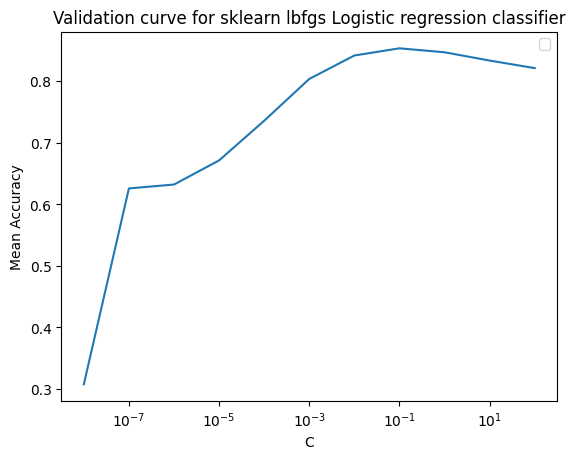

In [25]:
# sns.lineplot(x=np.logspace(-8, 2, 11), y=mean_accuracy)
# plt.xscale('log')
# plt.show()

plt.xlabel("C")
plt.ylabel("Mean Accuracy")
plt.xscale('log')
plt.title("Validation curve for sklearn lbfgs Logistic regression classifier")
plt.plot(np.logspace(-8, 2, 11), mean_accuracy)
plt.legend(loc="best")
plt.show()

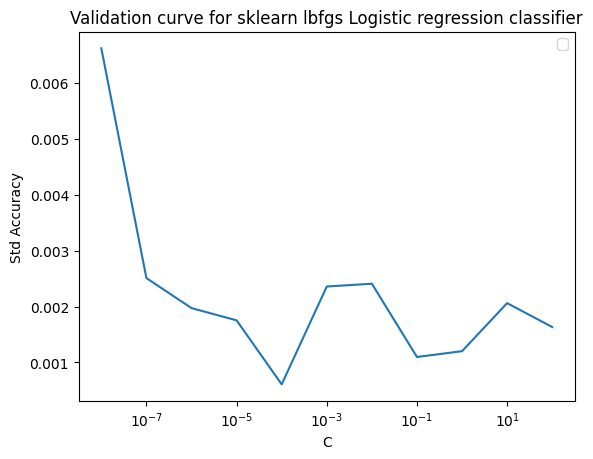

In [26]:
plt.xlabel("C")
plt.ylabel("Std Accuracy")
plt.xscale('log')
plt.title("Validation curve for sklearn lbfgs Logistic regression classifier")
plt.plot(np.logspace(-8, 2, 11), std_accuracy)
plt.legend(loc="best")
plt.show()

***Tìm C phù hợp với solver 'sag', tỷ lệ 6/4 để tiến hành hiệu chỉnh***

In [12]:
# Với tỷ lệ train/validation : 6/4
X_train3, X_val3, y_train3, y_val3, X_test3 = create_data(X=X, y=y, X_test=X_test, n_components=100, test_size=0.4)
X_train3.shape, X_val3.shape, X_test3.shape

((36000, 784), (24000, 784), (10000, 784))

In [13]:
# Chọn C với solver 'sag' với tỷ lệ train/validation : 6/4
model_logReg_sag = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2', n_jobs=-1)

parameters_sag = {'solver' : ['sag'],
         'C' : np.logspace(-8, 2, 11)}

clf = GridSearchCV(model_logReg_sag, parameters_sag, cv=3, n_jobs=-1)
clf.fit(X_train3, y_train3)
results = clf.cv_results_
best_parameter = clf.best_params_
best_score = clf.best_score_

c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [14]:
data = pd.DataFrame(results)
data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,12.655341,0.265606,0.019415,0.001963,1.000000e-08,sag,"{'C': 1e-08, 'solver': 'sag'}",0.617667,0.592083,0.600417,0.603389,0.010654,11
1,12.676105,0.867627,0.014317,0.001991,1.000000e-07,sag,"{'C': 1e-07, 'solver': 'sag'}",0.630417,0.627250,0.631750,0.629806,0.001887,10
2,10.783689,0.246575,0.013881,0.003903,1.000000e-06,sag,"{'C': 1e-06, 'solver': 'sag'}",0.637250,0.635167,0.633833,0.635417,0.001406,9
3,9.233824,0.166101,0.012763,0.002056,1.000000e-05,sag,"{'C': 1e-05, 'solver': 'sag'}",0.670250,0.669500,0.671083,0.670278,0.000647,8
4,8.346640,0.372801,0.017247,0.002628,1.000000e-04,sag,"{'C': 0.0001, 'solver': 'sag'}",0.729667,0.731500,0.728417,0.729861,0.001266,7
5,10.008283,0.525283,0.011350,0.001055,1.000000e-03,sag,"{'C': 0.001, 'solver': 'sag'}",0.798667,0.798917,0.800167,0.799250,0.000656,6
6,17.514012,0.983750,0.012458,0.001494,1.000000e-02,sag,"{'C': 0.01, 'solver': 'sag'}",0.844833,0.840583,0.839083,0.841500,0.002435,2
7,55.392417,2.204828,0.016239,0.004870,1.000000e-01,sag,"{'C': 0.1, 'solver': 'sag'}",0.853667,0.850500,0.851250,0.851806,0.001351,1
8,5706.555942,1.592782,0.015158,0.001399,1.000000e+00,sag,"{'C': 1.0, 'solver': 'sag'}",0.840833,0.843000,0.836750,0.840194,0.002591,3
9,6462.180127,155.106210,0.013664,0.001247,1.000000e+01,sag,"{'C': 10.0, 'solver': 'sag'}",0.830250,0.833583,0.825583,0.829806,0.003281,4


In [15]:
best_parameter

{'C': 0.1, 'solver': 'sag'}

In [16]:
mean_accuracy = data.iloc[:, -3]
std_accuracy = data.iloc[:, -2]
mean_accuracy, std_accuracy

(0     0.603389
 1     0.629806
 2     0.635417
 3     0.670278
 4     0.729861
 5     0.799250
 6     0.841500
 7     0.851806
 8     0.840194
 9     0.829806
 10    0.828083
 Name: mean_test_score, dtype: float64,
 0     0.010654
 1     0.001887
 2     0.001406
 3     0.000647
 4     0.001266
 5     0.000656
 6     0.002435
 7     0.001351
 8     0.002591
 9     0.003281
 10    0.003064
 Name: std_test_score, dtype: float64)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3732\1596273200.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


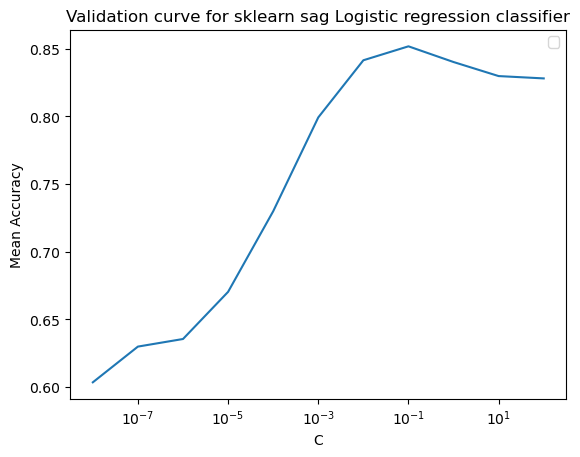

In [17]:
plt.xlabel("C")
plt.ylabel("Mean Accuracy")
plt.xscale('log')
plt.title("Validation curve for sklearn sag Logistic regression classifier")
plt.plot(np.logspace(-8, 2, 11), mean_accuracy)
plt.legend(loc="best")
plt.savefig('./mean_acc_sag')
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3732\694957301.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


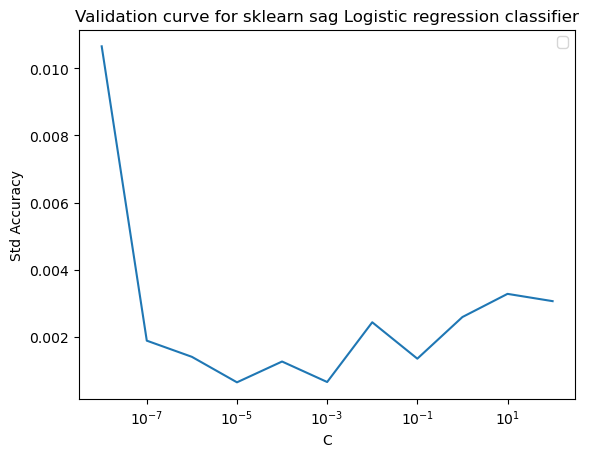

In [18]:
plt.xlabel("C")
plt.ylabel("Std Accuracy")
plt.xscale('log')
plt.title("Validation curve for sklearn sag Logistic regression classifier")
plt.plot(np.logspace(-8, 2, 11), std_accuracy)
plt.legend(loc="best")
plt.savefig('./std_acc_sag')
plt.show()

***Tìm C phù hợp với solver 'saga', tỷ lệ 6/4 để tiến hành hiệu chỉnh***

In [28]:
# Với tỷ lệ train/validation : 6/4
X_train3, X_val3, y_train3, y_val3, X_test3 = create_data(X=X, y=y, X_test=X_test, n_components=100, test_size=0.4)
X_train3.shape, X_val3.shape, X_test3.shape

((36000, 784), (24000, 784), (10000, 784))

In [29]:
# Chọn C với solver 'saga' với tỷ lệ train/validation : 6/4
model_logReg_saga = LogisticRegression(multi_class='multinomial', max_iter=10000, penalty='l2', n_jobs=-1)

parameters_saga = {'solver' : ['saga'],
         'C' : np.logspace(-8, 2, 11)}

clf1 = GridSearchCV(model_logReg_saga, parameters_saga, cv=3, n_jobs=-1)
clf1.fit(X_train3, y_train3)
results1 = clf1.cv_results_
best_parameter1 = clf1.best_params_
best_score1 = clf1.best_score_

c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [33]:
data = pd.DataFrame(results1)
data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,27.668003,2.833696,0.016681,0.000956,1.000000e-08,saga,"{'C': 1e-08, 'solver': 'saga'}",0.627417,0.477667,0.614167,0.573083,0.067686,11
1,19.118473,1.242008,0.018113,0.002112,1.000000e-07,saga,"{'C': 1e-07, 'solver': 'saga'}",0.631833,0.629250,0.630250,0.630444,0.001064,10
2,18.129711,1.177372,0.015758,0.002051,1.000000e-06,saga,"{'C': 1e-06, 'solver': 'saga'}",0.636833,0.634250,0.633833,0.634972,0.001327,9
3,19.164383,0.599146,0.018391,0.006197,1.000000e-05,saga,"{'C': 1e-05, 'solver': 'saga'}",0.670250,0.669500,0.670833,0.670194,0.000546,8
4,19.900883,0.411811,0.014501,0.001079,1.000000e-04,saga,"{'C': 0.0001, 'solver': 'saga'}",0.729583,0.731417,0.728417,0.729806,0.001235,7
5,35.176323,1.694134,0.012835,0.000849,1.000000e-03,saga,"{'C': 0.001, 'solver': 'saga'}",0.798667,0.798917,0.800167,0.799250,0.000656,6
6,72.313938,3.787405,0.014172,0.001616,1.000000e-02,saga,"{'C': 0.01, 'solver': 'saga'}",0.844833,0.840750,0.839083,0.841556,0.002416,2
7,159.187643,4.540849,0.015944,0.000598,1.000000e-01,saga,"{'C': 0.1, 'solver': 'saga'}",0.853833,0.850333,0.851250,0.851806,0.001482,1
8,8308.571652,6.627086,0.029428,0.000564,1.000000e+00,saga,"{'C': 1.0, 'solver': 'saga'}",0.842250,0.843083,0.838333,0.841222,0.002071,3
9,1712.529684,149.882938,0.019472,0.001952,1.000000e+01,saga,"{'C': 10.0, 'solver': 'saga'}",0.832833,0.835083,0.827250,0.831722,0.003293,4


In [34]:
best_parameter1

{'C': 0.1, 'solver': 'saga'}

In [35]:
best_score1

0.8518055555555555

In [40]:
mean_accuracy = data.iloc[:, -3]
std_accuracy = data.iloc[:, -2]
mean_accuracy, std_accuracy

(0     0.573083
 1     0.630444
 2     0.634972
 3     0.670194
 4     0.729806
 5     0.799250
 6     0.841556
 7     0.851806
 8     0.841222
 9     0.831722
 10    0.831667
 Name: mean_test_score, dtype: float64,
 0     0.067686
 1     0.001064
 2     0.001327
 3     0.000546
 4     0.001235
 5     0.000656
 6     0.002416
 7     0.001482
 8     0.002071
 9     0.003293
 10    0.003230
 Name: std_test_score, dtype: float64)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9816\2958206762.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


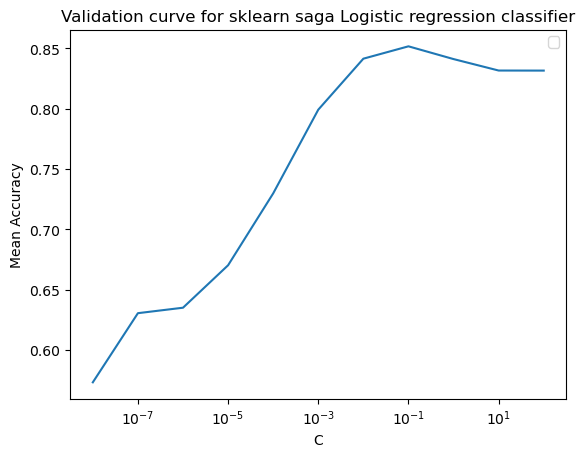

In [41]:
plt.xlabel("C")
plt.ylabel("Mean Accuracy")
plt.xscale('log')
plt.title("Validation curve for sklearn saga Logistic regression classifier")
plt.plot(np.logspace(-8, 2, 11), mean_accuracy)
plt.legend(loc="best")
plt.savefig('./mean_acc_saga')
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9816\4202196875.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


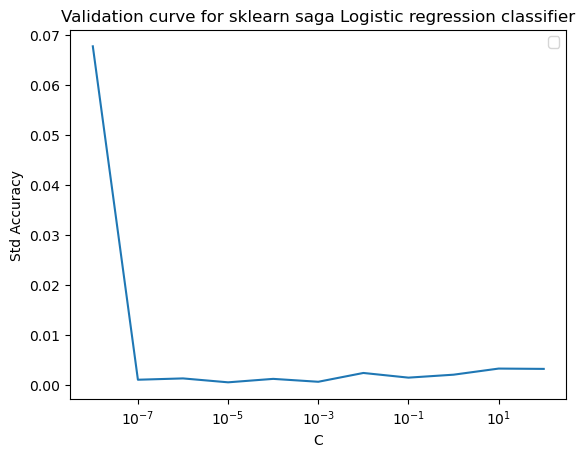

In [42]:
plt.xlabel("C")
plt.ylabel("Std Accuracy")
plt.xscale('log')
plt.title("Validation curve for sklearn saga Logistic regression classifier")
plt.plot(np.logspace(-8, 2, 11), std_accuracy)
plt.legend(loc="best")
plt.savefig('./std_acc_saga')
plt.show()